In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Load dataset
df = pd.read_csv("D:\Projects\Cyber Threat Detection\Dataset\cyber-threat-intelligence_all.csv")

In [3]:
# Check and fix duplicate column names
df.columns = [f"{col}_{i}" if df.columns.duplicated()[j] else col for j, col in enumerate(df.columns)]

In [4]:
# Find and rename the label column
for col in df.columns:
    if 'label' in col.lower():
        df = df.rename(columns={col: 'label'})
        break


In [5]:
# Drop missing or invalid labels
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(str).str.strip()
df = df[df['label'].str.lower() != 'nan']

In [6]:
print("Label classes (after cleaning):", df['label'].unique())

Label classes (after cleaning): ['malware' 'attack-pattern' 'TIME' 'identity' 'SOFTWARE' 'threat-actor'
 'location' 'tools' 'FILEPATH' 'SHA2' 'vulnerability' 'URL' 'DOMAIN'
 'IPV4' 'campaign' 'EMAIL' 'REGISTRYKEY' 'SHA1' 'Infrastucture' 'MD5'
 'url' 'hash']


In [7]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [ ]:
df.head()

,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset
0,0,1.0,This post is also available in: 日本語 (Japa...,"[{'id': 45800, 'label': 'malware', 'start_offs...",[],[],45800.0,malware,288.0,300.0
1,1,2.0,The attack vector is very basic and repeats it...,"[{'id': 48941, 'label': 'attack-pattern', 'sta...",[],[],48941.0,attack-pattern,69.0,115.0
3,3,4.0,The first known campaign was launched by Crim...,"[{'id': 45806, 'label': 'TIME', 'start_offset'...",[],[],45806.0,TIME,55.0,68.0
5,5,6.0,A very serious campaign was launched between ...,"[{'id': 22, 'label': 'identity', 'start_offset...",[],[],22.0,identity,90.0,108.0
8,8,9.0,Palo Alto Networks Enterprise Security Platfo...,"[{'id': 31, 'label': 'identity', 'start_offset...",[],[],31.0,identity,1.0,19.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9938 entries, 0 to 19939
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    9938 non-null   int64  
 1   index         9462 non-null   float64
 2   text          9938 non-null   object 
 3   entities      9462 non-null   object 
 4   relations     9462 non-null   object 
 5   Comments      9462 non-null   object 
 6   id            9462 non-null   float64
 7   label         9938 non-null   object 
 8   start_offset  9462 non-null   float64
 9   end_offset    9462 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 854.0+ KB


In [10]:
# Tokenize text
text_column = [col for col in df.columns if 'text' in col.lower()][0]
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df[text_column])
sequences = tokenizer.texts_to_sequences(df[text_column])
padded_sequences = pad_sequences(sequences, maxlen=200)

In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [12]:
# Build model
num_classes = len(label_encoder.classes_)
model = Sequential([
    Embedding(10000, 64, input_length=200),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

C:\Users\murali krishna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
df.head

<bound method NDFrame.head of        Unnamed: 0  index                                               text  \
0               0    1.0  This post is also available in:      日本語 (Japa...   
1               1    2.0  The attack vector is very basic and repeats it...   
2               2    3.0  Once executed by the user the first stage malw...   
3               3    4.0   The first known campaign was launched by Crim...   
4               4    5.0  The first stage downloaded the ransomware from...   
...           ...    ...                                                ...   
19935        5279    NaN  Cyclops Blink, an advanced modular botnet that...   
19936        1543    NaN   Sofacy Group has been associated with many at...   
19937       13595    NaN  The plugin has been designed to drop multiple ...   
19938        2368    NaN  We have uncovered a cyberespionage campaign be...   
19939       14267    NaN  Based on the analysis of samples that were las...   

                     

In [14]:
df.shape

(9938, 10)

In [15]:
# Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.1518 - loss: 2.7209 - val_accuracy: 0.2762 - val_loss: 2.2089
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.2795 - loss: 2.1079 - val_accuracy: 0.4804 - val_loss: 1.6202
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.5353 - loss: 1.4375 - val_accuracy: 0.6273 - val_loss: 1.2418
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.6937 - loss: 1.0152 - val_accuracy: 0.7113 - val_loss: 1.0718
Epoch 5/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7581 - loss: 0.8043 - val_accuracy: 0.7460 - val_loss: 1.0170


In [16]:
# Evaluate
pred_probs = model.predict(X_test)
y_pred = np.argmax(pred_probs, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [17]:
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))



Classification Report:
                 precision    recall  f1-score   support

        DOMAIN       0.00      0.00      0.00         8
         EMAIL       0.00      0.00      0.00         7
      FILEPATH       0.44      0.82      0.58        62
          IPV4       0.00      0.00      0.00        12
 Infrastucture       0.00      0.00      0.00         7
           MD5       0.00      0.00      0.00         3
   REGISTRYKEY       0.00      0.00      0.00         7
          SHA1       0.00      0.00      0.00        15
          SHA2       0.24      0.19      0.21        32
      SOFTWARE       0.80      0.73      0.77       218
          TIME       0.71      0.59      0.65       110
           URL       0.60      0.64      0.62        33
attack-pattern       0.80      0.86      0.83       239
      campaign       1.00      0.05      0.10        19
          hash       0.00      0.00      0.00         3
      identity       0.76      0.90      0.82       230
      location       0

C:\Users\murali krishna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\murali krishna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\murali krishna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pac

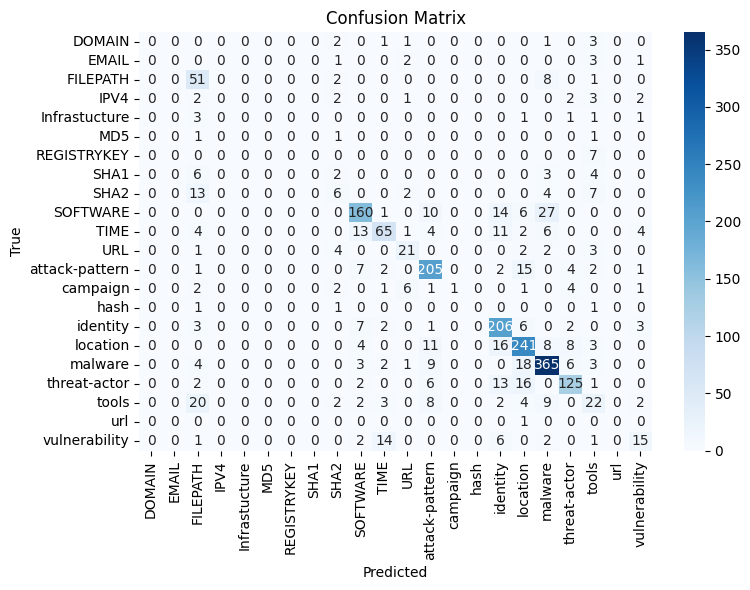

In [18]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



In [19]:
# Save model and assets
model.save("cyber_threat_model.keras")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

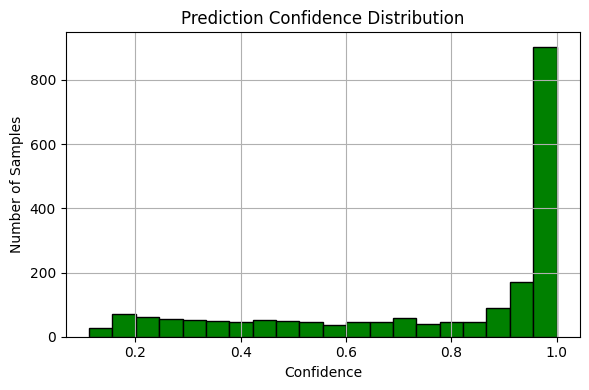

In [20]:
# Confidence Score Visualization
confidences = np.max(pred_probs, axis=1)
plt.figure(figsize=(6, 4))
plt.hist(confidences, bins=20, color='green', edgecolor='black')
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize

# ROC Curve (multiclass)
y_score = model.predict(X_test)
y_test_bin = label_binarize(y_test, classes=list(range(num_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


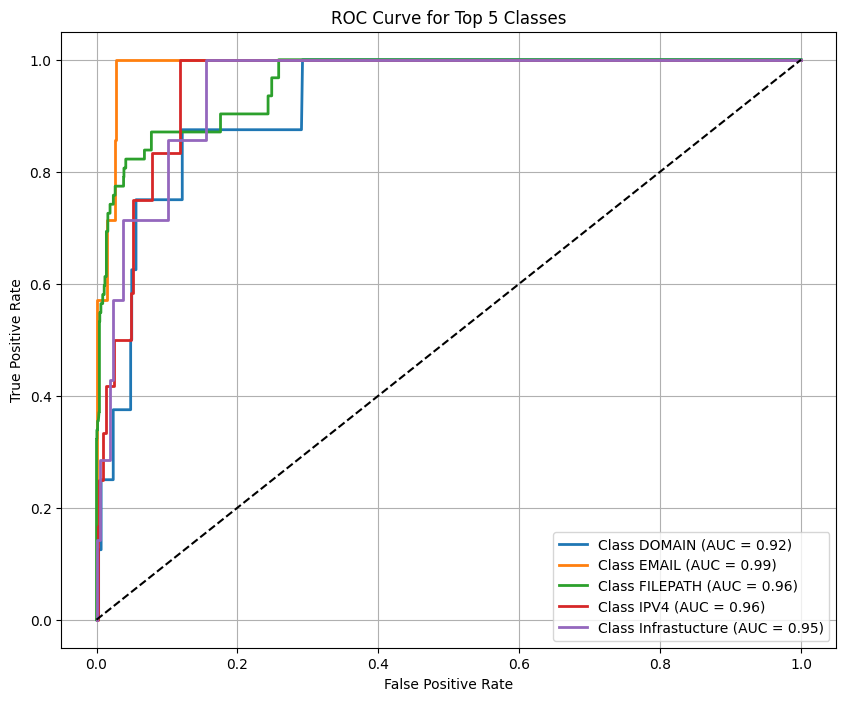

In [22]:
# Plot ROC for the first 5 classes
plt.figure(figsize=(10, 8))
for i in range(min(5, num_classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Top 5 Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()